In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.sixb.feynnet

In [3]:
use_signal = [ i for i, m in enumerate(module.full_signal_6b_list) if m in module.signal_6b_list ]

In [4]:
def use_test(f):
    return f.replace('ntuple','test_ntuple')

In [5]:
signal = ObjIter([Tree(use_test(f), report=False, ) for f in tqdm(module.full_signal_6b_list)])
bkg = ObjIter([Tree(map(use_test,module.Run2_UL18.QCD_B_List))])

100%|██████████| 16/16 [00:04<00:00,  3.59it/s]


In [6]:
import utils.sixbUtils as sixb

model = sixb.models.feynnet_bkg
(signal + bkg).apply( lambda t : sixb.weaver.load_yh_trih_ranker(t, model.path), report=True )

100%|██████████| 9/9 [00:33<00:00,  3.70s/it]


[None, None, None, None, None, None, None, None, None]

In [7]:
def fully_reconstructed(t):

    reco_hx = t.HX_signalId == 0
    reco_y  = ( (t.H1_signalId+1)//2 == 1) & ( (t.H2_signalId+1)//2 == 1)
    
    reco_id = ak.where( reco_hx & reco_y, 0, -1)
    t.extend(
        reco_id = reco_id
    )
(signal).apply(fully_reconstructed)

[None, None, None, None, None, None, None, None]

In [8]:
sixb_signal = signal.apply(EventFilter('all_sixb', filter=lambda t : t.nfound_select==6))
partial_signal = signal.apply(EventFilter('partial_sixb', filter=lambda t : t.nfound_select< 6))

100%|██████████| 1/1 [00:04<00:00,  4.33s/it]

x_mean=3.500
x_std=2.291
x_min=0.000
x_max=7.000
y_mean=0.750
y_std=0.060
y_min=0.654
y_max=0.858
x_sum=28.000
y_sum=5.998
area=5.198
ndf=8.000


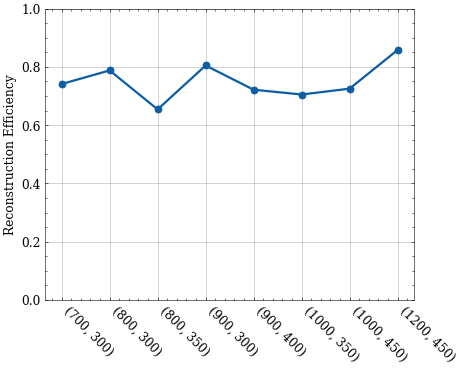

In [9]:
study.statsplot(
    sixb_signal,
    label=signal.mass.list,
    varlist=['reco_id'],
    binlist=[np.array([-1,0,1])],
    xlabels=['Reconstruction Efficiency'],
    efficiency=True,

    stat=lambda h:h.histo[-1],
    stat_err=lambda h:h.error[-1],
    g_grid=True,

    g_exe=lambda graph, **kwargs: print( f'{graph.stats:0.3f}'),
    g_ylim=(0,1),

)

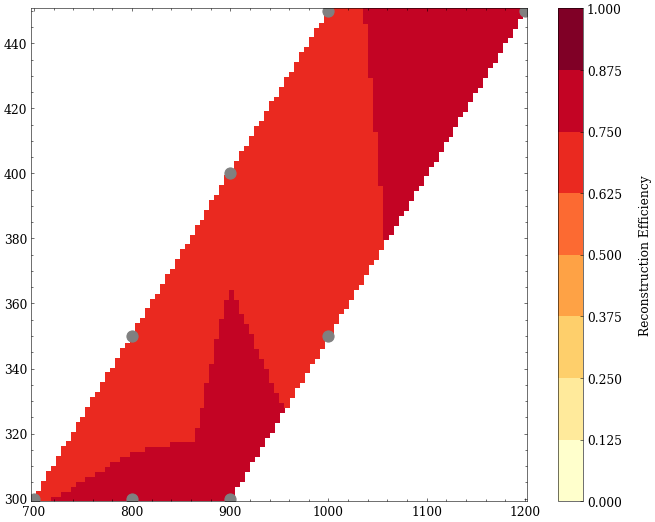

In [40]:
study.mxmy_phase(
    sixb_signal,
    label=signal.mass.list,
    zlabel='Reconstruction Efficiency',
    efficiency=True,

    f_var=lambda t: ak.mean(t.reco_id==0),
    zlim=np.linspace(0,1,9),
)

100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


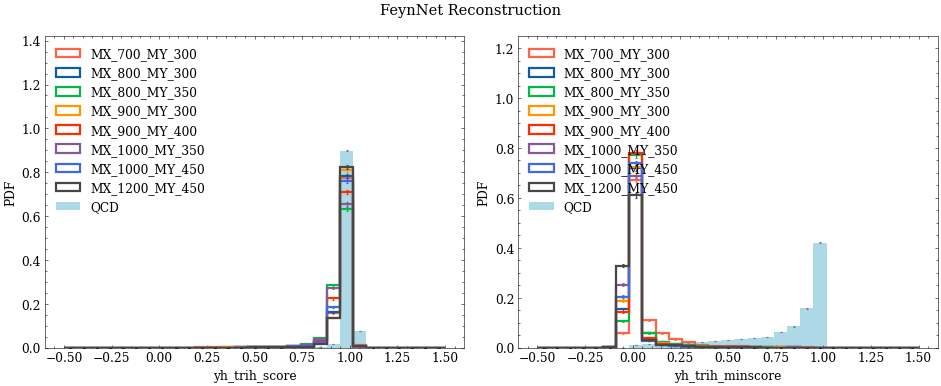

In [11]:
study.quick(
    sixb_signal+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['yh_trih_score','yh_trih_minscore'],
    binlist=[(-0.5,1.5,30)]*2,
    suptitle='FeynNet Reconstruction',
    efficiency=True,
    lumi=None,
    # **study.auroc,
)

In [12]:
varinfo.X_m =   dict(bins=(400,2000,30), xlabel='$M_{X}$ (GeV)')
varinfo.Y_m =  dict(bins=(100,1000,30), xlabel='Y Boson Mass (GeV)')
varinfo.HX_m =   dict(bins=(0,300,30), xlabel='X\'s Higgs Boson Mass (GeV)')
varinfo.H1_m =   dict(bins=(0,300,30), xlabel='Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2_m =   dict(bins=(0,300,30), xlabel='Y\'s Subleading Higgs Boson Mass (GeV)')


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


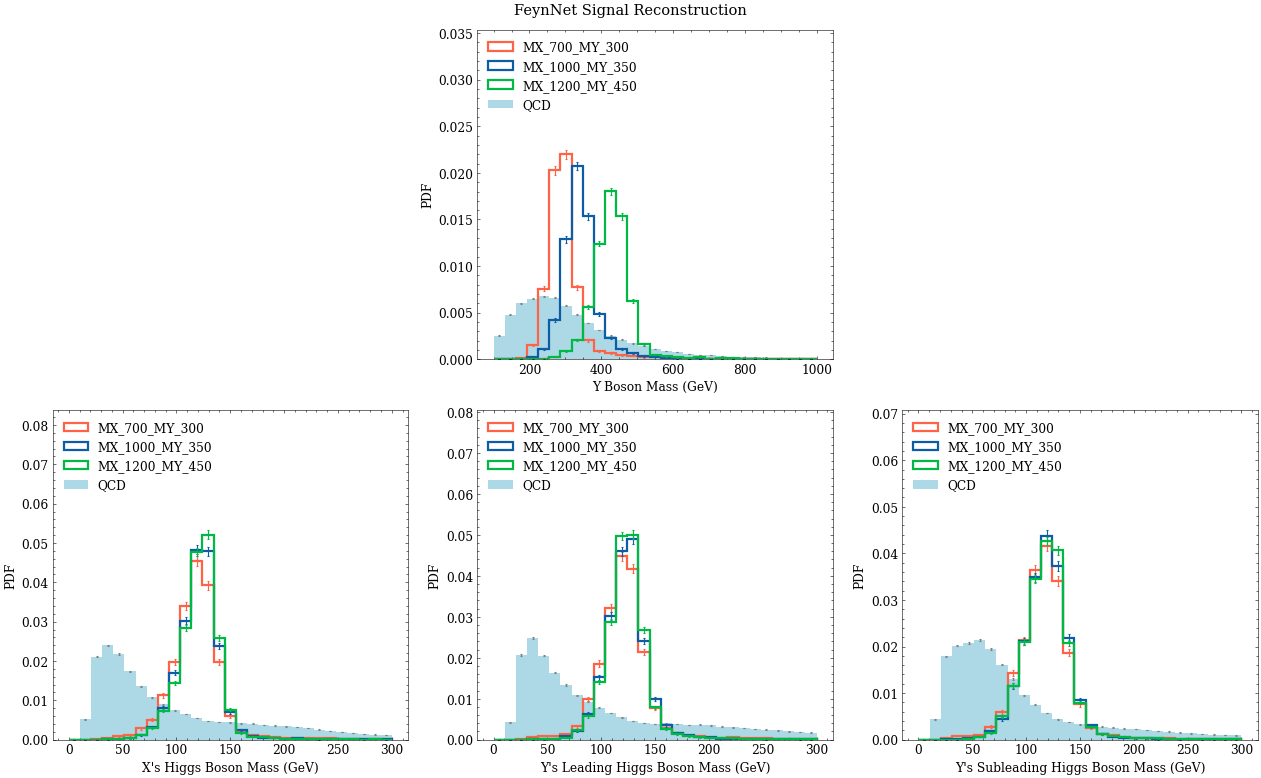

In [13]:
study.quick(
    sixb_signal[use_signal]+bkg,
    legend=True,
    h_label_stat=None,
    varlist=[None,'Y_m',None,'HX_m','H1_m','H2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)

In [15]:
trg = 'HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5'

100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


x_mean=3.500
x_std=2.291
x_min=0.000
x_max=7.000
y_mean=0.759
y_std=0.058
y_min=0.666
y_max=0.862
x_sum=28.000
y_sum=6.073
area=5.261
ndf=8.000


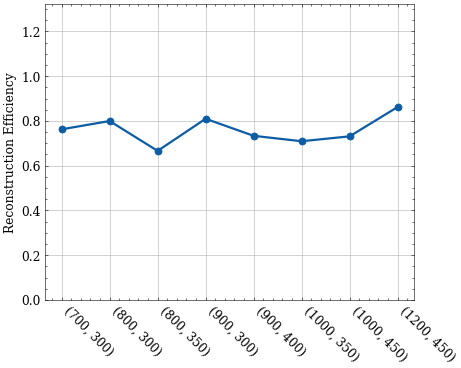

In [18]:
study.statsplot(
    sixb_signal,
    masks=lambda t : t[trg] == 1,
    label=signal.mass.list,
    varlist=['reco_id'],
    binlist=[np.array([-1,0,1])],
    xlabels=['Reconstruction Efficiency'],
    efficiency=True,

    stat=lambda h:h.histo[-1],
    stat_err=lambda h:h.error[-1],
    g_grid=True,

    g_exe=lambda graph, **kwargs: print( f'{graph.stats:0.3f}'),
)

100%|██████████| 6/6 [00:00<00:00,  7.14it/s]


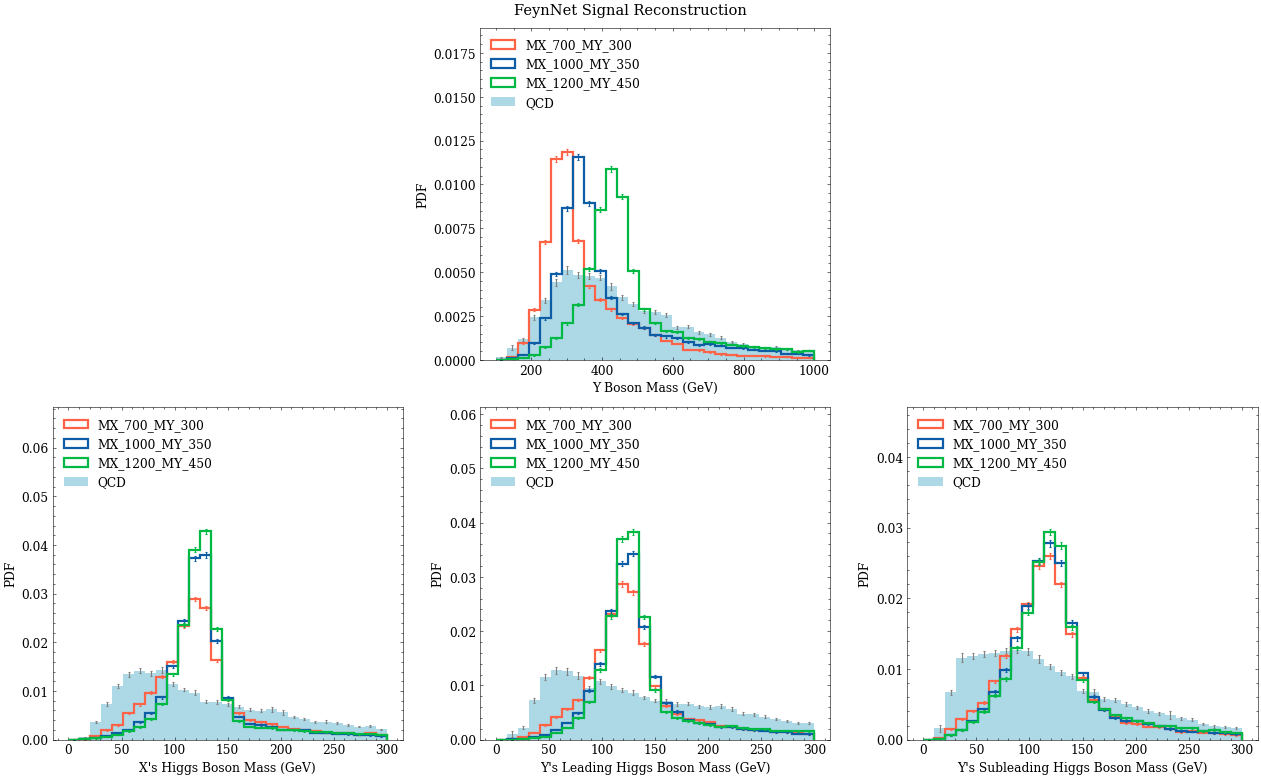

In [20]:
study.quick(
    signal[use_signal]+bkg,
    masks=lambda t:t[trg]==1,
    legend=True,
    h_label_stat=None,
    varlist=[None,'Y_m',None,'HX_m','H1_m','H2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)

In [29]:
def n_loose_btag(t): return ak.sum(t.jet_btag > jet_btagWP[1], axis=1)

In [31]:
trg_mask = lambda t : t[trg]==1
higgs_sr = lambda t : ak.sum( (t.higgs_m-125)**2, axis=1 ) < (30)**2
six_loose_btag = lambda t : n_loose_btag(t) == 6

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


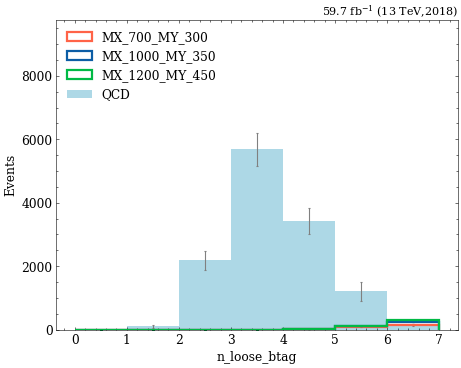

In [32]:
study.quick(
    signal[use_signal]+bkg,
    masks=lambda t: trg_mask(t) & higgs_sr(t),
    legend=True,
    h_label_stat=None,
    varlist=[n_loose_btag],
    # lumi=None,
    # density=True,
)

100%|██████████| 6/6 [00:01<00:00,  4.18it/s]


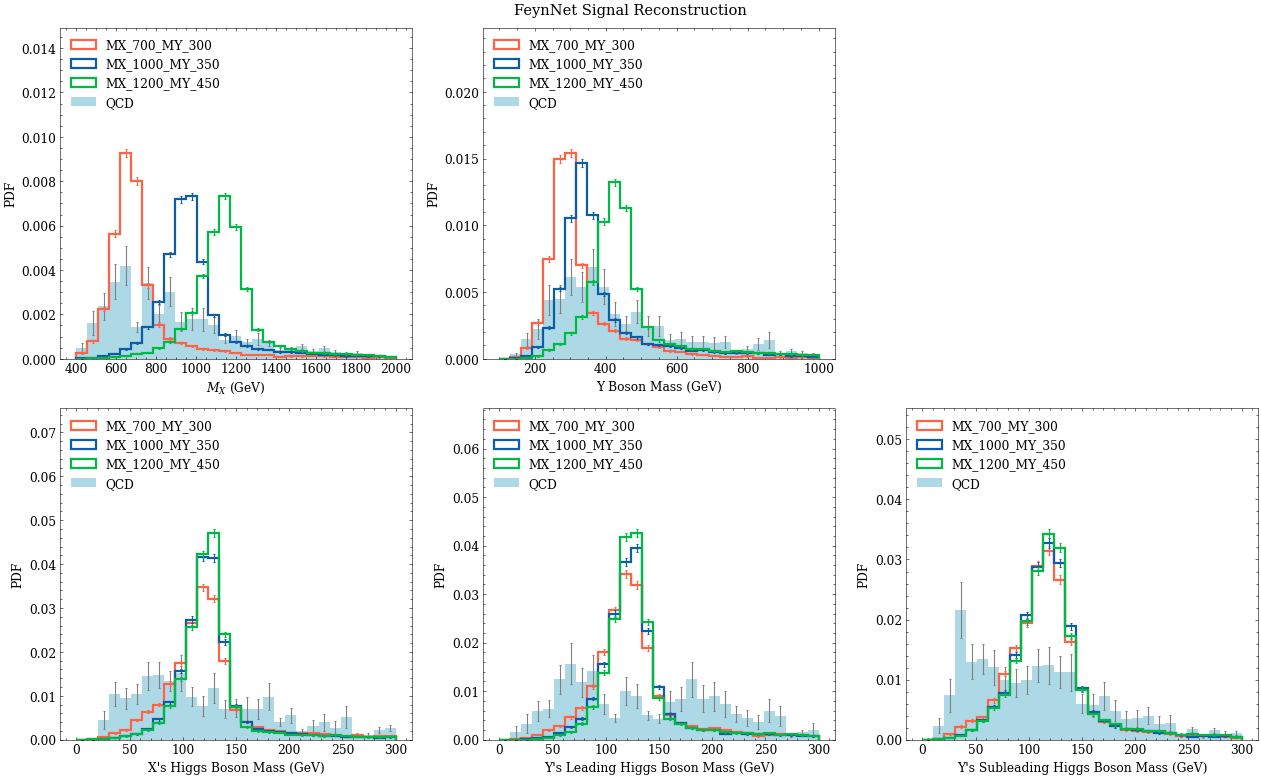

In [35]:
study.quick(
    signal[use_signal]+bkg,
    masks=lambda t: trg_mask(t) & six_loose_btag(t),
    legend=True,
    h_label_stat=None,
    varlist=['X_m','Y_m',None,'HX_m','H1_m','H2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)